In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
from PIL import Image
import torch
from torch import nn
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Compose, Resize, Grayscale, ToPILImage
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import get_confusion_matrix
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

#from data_split import data_separator, get_oversampling
#from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
#from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
#from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

2024-06-06 15:35:36.103326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 15:35:36.339868: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 15:35:37.071357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib
2024-06-06 15:35:37.071539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynam

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [3]:
df = pd.read_csv("/home/12559743/DAVI/IC/Codes/data_aug.csv")
print(len(df))

1455


In [4]:
print(df.iloc[1450]['Patient'], df.iloc[1450]['PAN Date'], df.iloc[1450]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


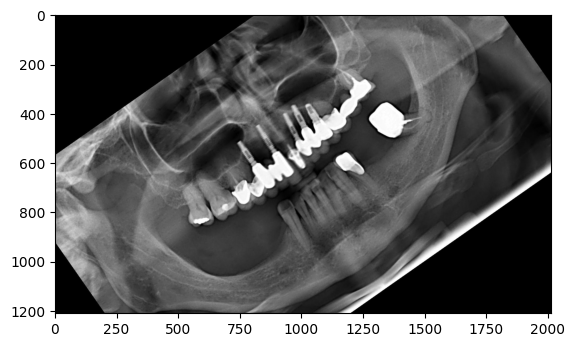

In [5]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

In [6]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Patient,Sex,Date of birth,PAN Date,Age at PAN,PAN Path
0,0,0.0,0.0,SEBASTIAO ABAQUI,1,24/05/1943,25/10/2016,74.0,/home/12559743/DAVI/todos_pacientes/ABAQUI SEB...
1,1,1.0,1.0,ABEGAIR SOUZA SILVA,1,03/03/1981,28/09/2018,38.0,/home/12559743/DAVI/todos_pacientes/ABEGAIR SO...
2,2,2.0,2.0,ABEL GONCALVES DA CUNHA,1,01/03/1970,05/10/2016,47.0,/home/12559743/DAVI/todos_pacientes/ABEL GONÇA...
3,3,3.0,3.0,ABELARDO RODRIGUES DA SILVA,1,04/01/1977,13/11/2018,42.0,/home/12559743/DAVI/todos_pacientes/ABELARDO R...
4,4,4.0,4.0,JOSE BENEDITO DE ABREU,1,29/09/1938,13/04/2016,78.0,/home/12559743/DAVI/todos_pacientes/ABREU JOSE...


In [7]:
df_subset = df[['PAN Path', 'Sex']]
df_subset.to_csv('Patient_Sex.csv', index = False)



In [8]:
df_subset.iloc[0][0]

'/home/12559743/DAVI/todos_pacientes/ABAQUI SEBASTIAO/SEBASTIAO ABAQUI- -- - - - 24-05-1943- PX from 25-10-2016 S0 I0(1)_cr.jpg'

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx,0]
        image = Image.open(img_path)
        image = image.resize((224,224))
        image = image.convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
transform = Compose([
    Resize((224,224)),
    #Grayscale(),
    ToTensor()
])

dataset = CustomImageDataset(annotations_file='Patient_Sex.csv', transform=transform)


In [10]:
img_test = read_image('/home/12559743/DAVI/todos_pacientes/ABAQUI SEBASTIAO/SEBASTIAO ABAQUI- -- - - - 24-05-1943- PX from 25-10-2016 S0 I0(1)_cr.jpg')
print(type(img_test))  # Check the type of the loaded image

# Since the image is already a tensor, you can directly use it
tensor_img = img_test
print(type(tensor_img))


<class 'torch.Tensor'>
<class 'torch.Tensor'>


Amostra 1
Forma da imagem antes da transformação ToTensor: torch.Size([3, 224, 224])
Rótulo: 1



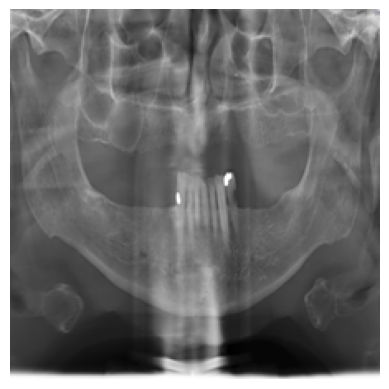

Amostra 2
Forma da imagem antes da transformação ToTensor: torch.Size([3, 224, 224])
Rótulo: 1



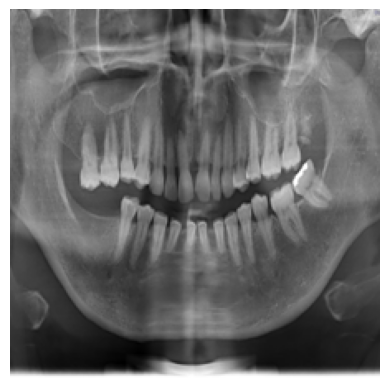

Amostra 3
Forma da imagem antes da transformação ToTensor: torch.Size([3, 224, 224])
Rótulo: 1



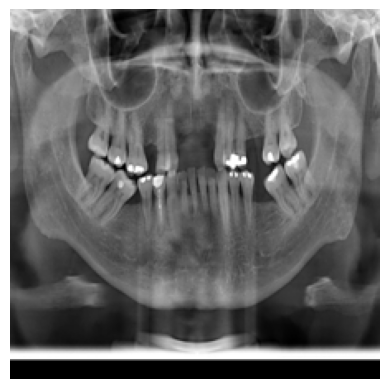

Amostra 4
Forma da imagem antes da transformação ToTensor: torch.Size([3, 224, 224])
Rótulo: 1



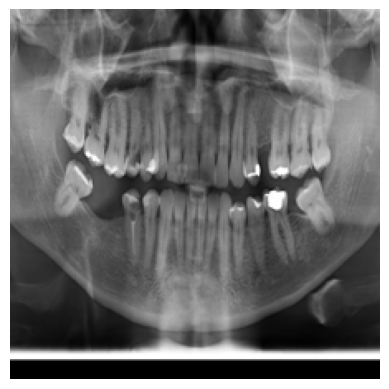

Amostra 5
Forma da imagem antes da transformação ToTensor: torch.Size([3, 224, 224])
Rótulo: 1



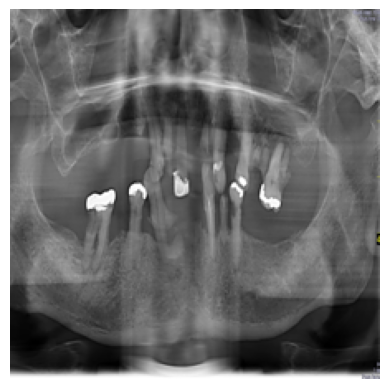

In [11]:
import matplotlib.pyplot as plt

# Imprima algumas amostras do conjunto de dados
for i in range(min(5, len(dataset))):
    sample = dataset[i]
    image = sample[0]  # Obter a imagem
    label = sample[1]  # Obter o rótulo
    print("Amostra", i+1)
    
    # Verifique a forma da imagem antes da transformação ToTensor()
    print("Forma da imagem antes da transformação ToTensor:", image.shape)
    
    # Acesse o rótulo
    print("Rótulo:", label)
    print()

    # Converte o tensor de imagem para NumPy array e transpõe as dimensões para (H, W, C)
    image_np = image.permute(1, 2, 0).numpy()

    image_np = image_np.clip(0,1)

    # Mostra a imagem usando Matplotlib
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()


In [12]:
training_data, test_data = train_test_split(dataset, test_size=0.3, shuffle=True, random_state=21)

#val_data, test_data = train_test_split(dataset, test_size=0.5, shuffle=True, random_state=21)

In [13]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.Size([3, 224, 224])


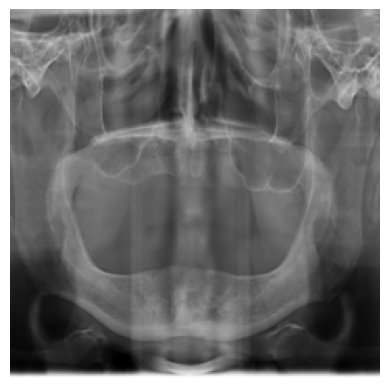

Label: 1
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.Size([3, 224, 224])


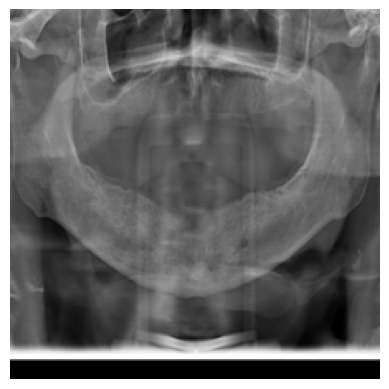

Label: 1
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.Size([3, 224, 224])


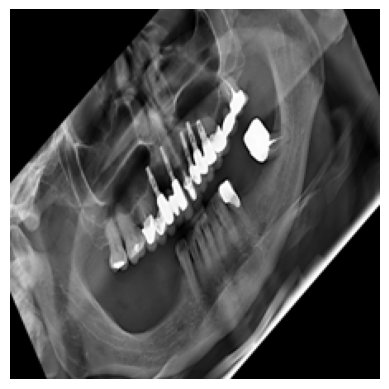

Label: 0
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.Size([3, 224, 224])


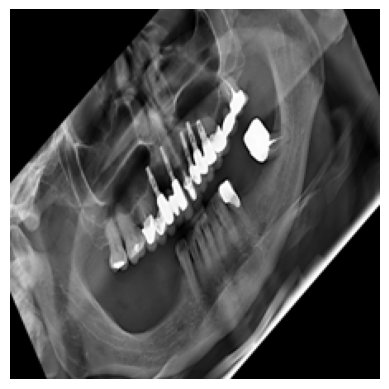

Label: 0
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
torch.Size([3, 224, 224])


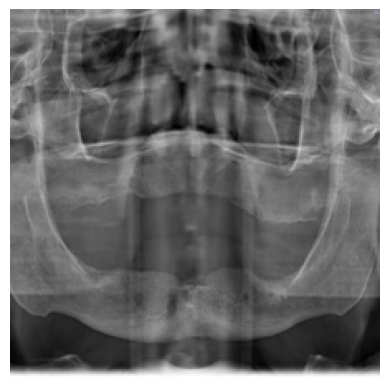

Label: 1


In [14]:

batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)


for i in range(5):
    train_features, train_labels = next(iter(train_dataloader))
    
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    
    img = train_features[0].squeeze()
    print(img.shape)
    
    label = train_labels[0]
    img = img.permute(1, 2, 0)
    
    plt.imshow(img)  
    plt.axis('off')
    plt.show()
    
    print(f"Label: {label}")


In [15]:
class MLPerceptron(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flaten()
        
        self.layers = nn.Sequential(
            nn.Linear(224*224, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.Sigmoid(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        v = self.flatten(x)
        return self.layers(v)


In [16]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv32_1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding='same', bias=False)
        self.conv32_2 = nn.Conv2d(32,32, kernel_size=3, stride=1, padding='same', bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv64_1 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding='same', bias = False )
        self.conv64_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same', bias=False)
        self.conv32resid = nn.Conv2d(32, 32, kernel_size=1, stride=2, bias=False)
        self.conv64resid = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)
        self.avg = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(50176, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv32_1(x)
        x = self.relu(x)
        y = self.maxpool(x)
        x = self.conv32_2(y)
        x = self.relu(x)
        x = self.maxpool(x)
        residual = self.conv32resid(y)
        residual = self.relu(residual)
        y = residual + x

        x = self.conv64_1(y)
        x = self.relu(x)
        x = self.conv64_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        residual = self.conv64resid(y)
        residual = self.relu(residual)
        y = residual + x
        

        x = torch.flatten(y, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.out(x)
        x = self.sigmoid(x)
        
        return x
    

model = ResNet()
#model.apply(lambda m: nn.init.constant_(m.weight, 0.5) if type(m) == nn.Linear else None)
model.to(device)


ResNet(
  (conv32_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (conv32_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv64_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (conv64_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (conv32resid): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (conv64resid): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (avg): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [17]:
loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


#auc_metrics = get_confusion_matrix()

In [18]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [19]:
import numpy as np

def normalize_data(data):
    """ Normalize the data to the range [0, 1]. """
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val - min_val == 0:
        return np.zeros_like(data)
    return (data - min_val) / (max_val - min_val)

def calculate_probabilities(data, num_bins):
    """ Calculate the probability distribution of the data. """
    counts, _ = np.histogram(data, bins=num_bins, density=True)
    probabilities = counts/np.sum(counts)
    return probabilities[probabilities > 0]  # Remove zero probabilities

def shannon_entropy(probabilities):
    """ Calculate the Shannon entropy. """
    return -np.sum(probabilities * np.log(probabilities))

def disequilibrium(probabilities, num_bins):
    """ Calculate the disequilibrium. """
    equi_prob = 1.0 / num_bins
    return np.sqrt(np.sum((probabilities - equi_prob)**2))

def lmc_complexity(data, num_bins=100):
    """ Calculate the LMC complexity of the data. """
    normalized_data = normalize_data(data)
    probabilities = calculate_probabilities(normalized_data, num_bins)
    H = shannon_entropy(probabilities)
    D = disequilibrium(probabilities, num_bins)
    C = H * D
    return H, D, C

In [20]:
'''
probablidades = calculate_probabilities(nomralized_myp, num_bins=100)
#probablidades
entropia = shannon_entropy(probablidades)
entropia
'''

'\nprobablidades = calculate_probabilities(nomralized_myp, num_bins=100)\n#probablidades\nentropia = shannon_entropy(probablidades)\nentropia\n'

In [21]:
from sklearn.metrics import accuracy_score

epochs = 80
min_valid_loss = np.inf
loss_values_train = []
loss_values_val = []

acc_values_train = []
acc_values_val = []

single_complexity = list()
single_entropy = list()
single_disequilibrium = list()

for e in range(epochs):
    y_pred_train = []
    y_true_train = []

    train_loss = 0.0
    model.train()     
    for data, labels in train_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data)
        loss = loss_function(target,labels)
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0) 
        
        _, preds = torch.max(target, dim=1)
        y_pred_train.append(preds.tolist())
        y_true_train.append(labels.tolist())

    y_pred_train = [item for sublist in y_pred_train for item in sublist]
    y_true_train = [item for sublist in y_true_train for item in sublist]
    train_acc = accuracy_score(y_true_train, y_pred_train)
    acc_values_train.append(train_acc)
    loss_values_train.append(train_loss / len(train_dataloader))

    myp = torch.nn.utils.parameters_to_vector(model.parameters())
    myp = myp.cpu().detach().numpy()
    entropia, disequilibrio, complexidade = lmc_complexity(myp)
    single_complexity.append(complexidade)
    single_entropy.append(entropia)
    single_disequilibrium.append(disequilibrio)

    
    y_pred_val = []
    y_true_val = []
    
    valid_loss = 0.0
    model.eval()     
    for data, labels in test_dataloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = loss_function(target,labels)
        valid_loss += loss.item() * data.size(0)
        
        _, preds = torch.max(target, dim=1)
        y_pred_val.append(preds.tolist())
        y_true_val.append(labels.tolist())
        
    y_pred_val = [item for sublist in y_pred_val for item in sublist]
    y_true_val = [item for sublist in y_true_val for item in sublist]
    val_acc = accuracy_score(y_true_val, y_pred_val)
    acc_values_val.append(val_acc)
    loss_values_val.append(valid_loss / len(test_dataloader))
    
    print(f'Epoch {e+1}: \n Training Loss: {train_loss/len(train_dataloader)} \t Training Acc: {train_acc} \n Validation Loss: {valid_loss/len(test_dataloader)} \t Validation Acc: {val_acc}')
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'resnet_model.pth')

Epoch 1: 
 Training Loss: 20.099725503474474 	 Training Acc: 0.6699410609037328 
 Validation Loss: 17.160431610686437 	 Validation Acc: 0.7208237986270023
Epoch 2: 
 Training Loss: 17.597575813531876 	 Training Acc: 0.7328094302554028 
 Validation Loss: 16.339989636625564 	 Validation Acc: 0.8009153318077803
Epoch 3: 
 Training Loss: 16.947370432317257 	 Training Acc: 0.762278978388998 
 Validation Loss: 15.697376447064537 	 Validation Acc: 0.8260869565217391
Epoch 4: 
 Training Loss: 16.36333578452468 	 Training Acc: 0.7858546168958742 
 Validation Loss: 15.595562777348928 	 Validation Acc: 0.7940503432494279
Epoch 5: 
 Training Loss: 16.09455458074808 	 Training Acc: 0.7838899803536346 
 Validation Loss: 15.952133251088005 	 Validation Acc: 0.7688787185354691
Epoch 6: 
 Training Loss: 15.496987400576472 	 Training Acc: 0.8172888015717092 
 Validation Loss: 15.397760340145656 	 Validation Acc: 0.8077803203661327
Epoch 7: 
 Training Loss: 15.35769423469901 	 Training Acc: 0.81827111984

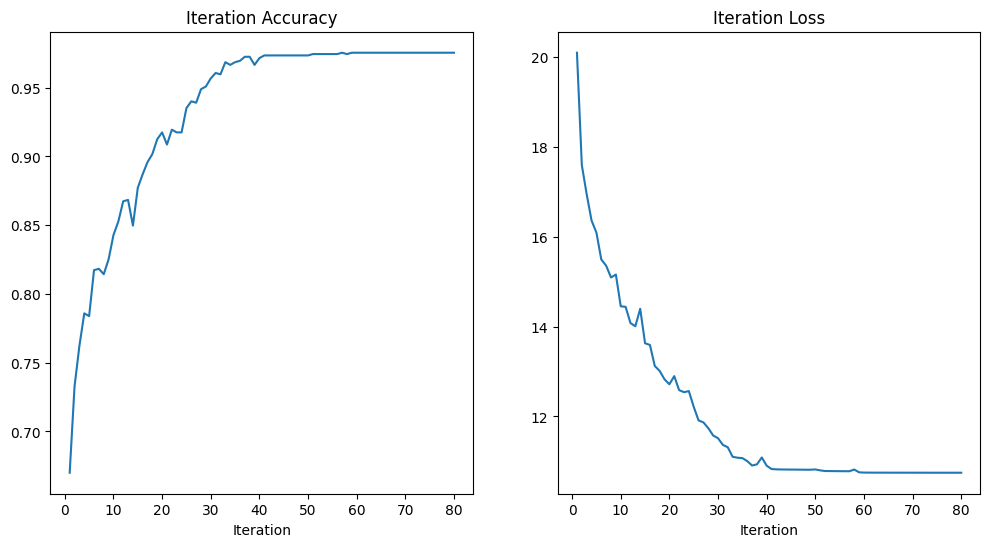

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1,2,1)
plt.title("Iteration Accuracy")
x = [i + 1 for i in range(len(acc_values_train))]
y = acc_values_train
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Iteration Loss")
x = [1 * (i + 1) for i in range(len(loss_values_train))]
y = loss_values_train
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()



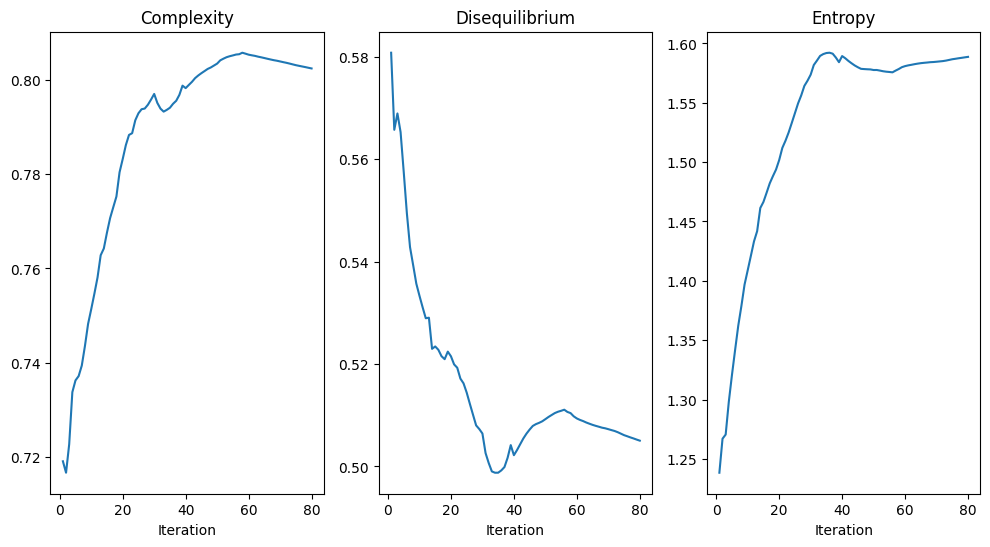

In [25]:
plt.figure("train", (12, 6))
plt.subplot(1,3,1)
plt.title("Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,3,2)
plt.title("Disequilibrium")
x = [1 * (i + 1) for i in range(len(single_disequilibrium))]
y = single_disequilibrium
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,3,3)
plt.title("Entropy")
x = [1 * (i + 1) for i in range(len(single_entropy))]
y = single_entropy
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()



In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1,2,1)
plt.title("Iteration Accuracy")
x = [i + 1 for i in range(len(acc_values_train))]
y = acc_values_train
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Iteration Loss")
x = [1 * (i + 1) for i in range(len(loss_values_train))]
y = loss_values_train
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()



In [ ]:
labels

In [ ]:

pred = torch.round(target.squeeze())
max = torch.max(pred)
print(max)


In [ ]:
class ConvolutionalModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3,3)),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=(5,5)),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=(2,2)),
            nn.ReLU(),
            nn.Dropout2d(0.2),


            nn.MaxPool2d(2,2)
        )
        self.linearlayer = nn.Sequential(
            nn.Linear(746496, 256),
            nn.Dropout(0.2),
            nn.Sigmoid(),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x,1)
        return self.linearlayer(x)

In [ ]:
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)

In [ ]:
#model = ConvolutionalModel()
model.to(device)
for param in model.parameters():
    param.requires_grad = True
print(model)

In [ ]:
def train(model, dataloader, lossfunction, optimizer):
    model.train()
    cumloss = 0.0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = model(imgs)
        pred = pred.argmax(dim=-1).float()

        loss = lossfunction(pred,labels.float())
        loss.requires_grad = True

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        cumloss += loss.item()
    return cumloss/len(dataloader)

def validation(dataloader, model, loss_fn):
    
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred = pred.argmax(dim=-1)
            test_loss += loss_fn(pred.float(), y.float()).item()
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct




In [ ]:
loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-3)


#auc_metrics = get_confusion_matrix()

In [ ]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        prob = histogram
        log_prob = histogram.log()
        plogp = prob*log_prob
        plogp[torch.isnan(plogp)] = 0
        return plogp.sum().detach().cpu().numpy()

    def desiquilibrium(self, p):
        histogram = torch.histc(p.detach(), bins=self.bins)
        histogram = histogram - self.normal_prob()
        return histogram.square().sum().cpu().numpy()

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)


    def normal_prob(self):
        return 1.0/self.bins

def extract_model_data(model, model_data=None):
    if model_data is None:
        model_data = dict()
    c = Complexity()
    for name, param in model.named_parameters():
        if param.requires_grad:
            # we got a valid parameter to extract
            if name not in model_data.keys():
                model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
            model_data[name]['entropy'].append(c.entropy(param.data))
            model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
            model_data[name]['complexity'].append(c.complexity(param.data))
    return model_data

In [ ]:
epochs = 100
train_losses = []
test_losses= []
test_accuracy_list = []
single_complexity = list()
single_entropy = list()
single_disequilibrium = list()
model.to(device)
model_data =None
best_metric=0

for t in range(epochs):
    train_loss = train(model=model, dataloader= train_dataloader, lossfunction=loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    model_data = extract_model_data(model)
    myp = torch.nn.utils.parameters_to_vector(model.parameters())
    single_complexity.append(Complexity().complexity(myp))
    single_disequilibrium.append(Complexity().entropy(myp))
    single_entropy.append(Complexity().entropy(myp))
    if t % 10 ==0:
        print(f'Epoch {t}; Train Loss {train_loss}')
    test_loss, test_accuracy = validation(model=model, dataloader=test_dataloader,loss_fn=loss_function)
    test_losses.append(test_loss)
    test_accuracy_list.append(test_accuracy)


In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1,2,1)
plt.title("Iteration Complexity")
x = [i + 1 for i in range(len(single_complexity))]
y = single_complexity
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1,2,2)
plt.title("Iteration Loss")
x = [1 * (i + 1) for i in range(len(test_losses))]
y = test_losses
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()



In [ ]:
single_disequilibrium

In [ ]:
plt.plot(single_disequilibrium)

In [ ]:
plt.plot(single_entropy)